# Steps for [tensorflow/tensorflow:latest-jupyter](https://hub.docker.com/r/tensorflow/tensorflow)

## For pip
- --upgrade pip
- sklearn
- opencv-python
- imutils

## For the OS
- apt-get update
- apt-get install libsm6 libxext6 ffmpeg -y

In [1]:
# Import Keras Stuff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

In [2]:
# Other Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import os

In [3]:
# Learning rate, number of epochs and batch size
EPOCHS = 20
LR = 1e-4
BS = 15

In [4]:
# Variables for loading all the images
image_paths = list(paths.list_images('dataset'))
dataset_folder = os.listdir('dataset')
dataset_sizes = [len(os.listdir('dataset/'+folder)) for folder in dataset_folder]
data = []
labels = [] 

In [5]:
for image_path in image_paths:
    # extract the class label from the filename
    label = image_path.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [6]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


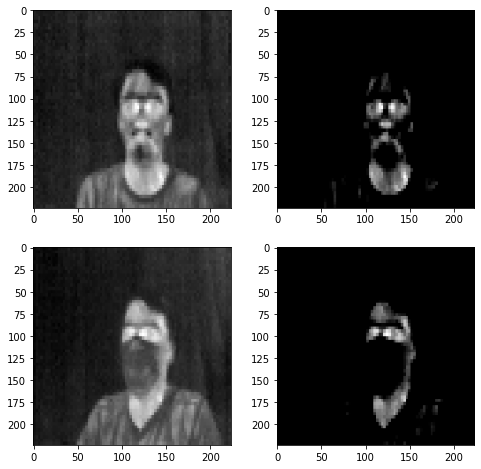

In [7]:
figure, axis = plt.subplots(2, 2, figsize=(8, 8))
axis[0,1].imshow(data[0])
axis[1,1].imshow(data[dataset_sizes[0]])
axis[0,0].imshow(load_img(image_paths[0], target_size=(224, 224)))
axis[1,0].imshow(load_img(image_paths[dataset_sizes[0]], target_size=(224, 224)))

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [12]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
# compile our model
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [16]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/20
15/15 [==============================] - 6s 227ms/step - loss: 0.8829 - accuracy: 0.5070 - val_loss: 0.6388 - val_accuracy: 0.7105
Epoch 2/20
15/15 [==============================] - 3s 178ms/step - loss: 0.8098 - accuracy: 0.4933 - val_loss: 0.5602 - val_accuracy: 0.6842
Epoch 3/20
15/15 [==============================] - 3s 171ms/step - loss: 0.6112 - accuracy: 0.6761 - val_loss: 0.4580 - val_accuracy: 0.9211
Epoch 4/20
15/15 [==============================] - 3s 175ms/step - loss: 0.5559 - accuracy: 0.7183 - val_loss: 0.4305 - val_accuracy: 0.8158
Epoch 5/20
15/15 [==============================] - 3s 173ms/step - loss: 0.4496 - accuracy: 0.8239 - val_loss: 0.3744 - val_accuracy: 0.8947
Epoch 6/20
15/15 [==============================] - 3s 171ms/step - loss: 0.4586 - accuracy: 0.8239 - val_loss: 0.3430 - val_accuracy: 0.8947
Epoch 7/20
15/15 [==============================] - 3s 169ms/step - loss: 0.4048 - accuracy: 0.8732 - val_loss: 0.2916 - val_accuracy: 0.9474
Epoch 

In [17]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

In [18]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00        19
without_mask       1.00      1.00      1.00        19

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [20]:
# serialize the model to disk
model.save('thermal_mask_detector.model', save_format="h5")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
# plot the training loss and accuracy
def make_graph(axis, x, y1, y2, label_1, label_2, title, x_label, y_label):
    line_1, = axis.plot(x, y1)
    line_1.set_label(label_1)
    line_2, = axis.plot(x, y2)
    line_2.set_label(label_2)
    axis.legend()
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    return ax1, ax2

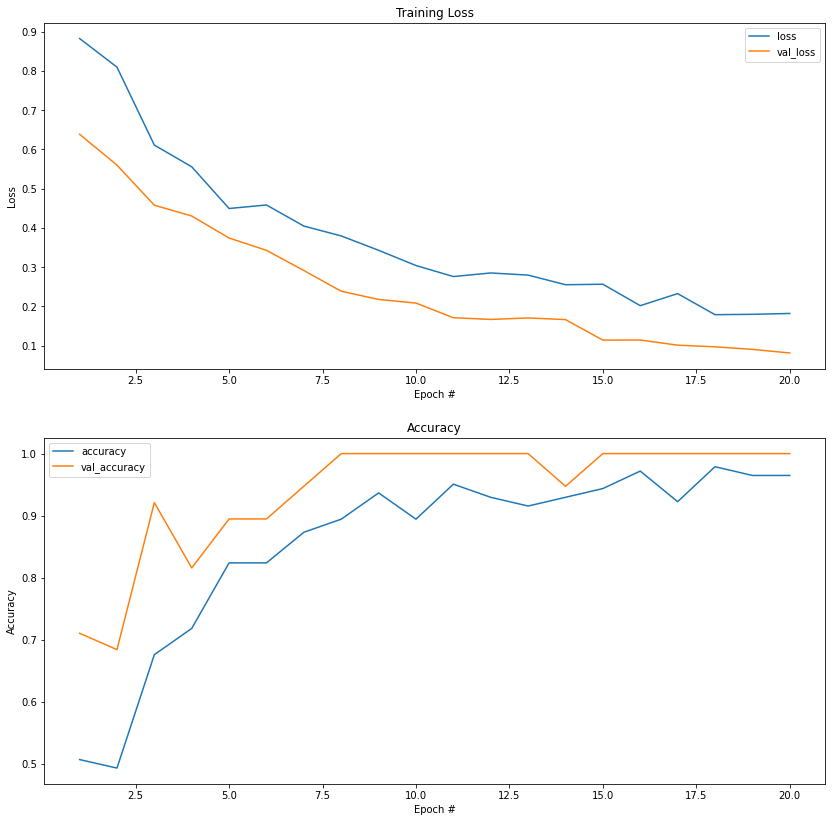

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,14))
make_graph(ax1, np.arange(1, EPOCHS + 1), H.history["loss"], H.history["val_loss"], 'loss', 'val_loss', 'Training Loss', 'Epoch #', 'Loss')
make_graph(ax2, np.arange(1, EPOCHS + 1), H.history["accuracy"], H.history["val_accuracy"], 'accuracy', 'val_accuracy', 'Accuracy', 'Epoch #', 'Accuracy')
plt.show()